### Cab-Driver Agent

In [2]:
from google.colab import files

uploaded = files.upload()

Saving Env.py to Env.py
Saving TM.npy to TM.npy


In [3]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

#### Defining Time Matrix

In [4]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [5]:
env = CabDriver()

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [6]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.6
        self.learning_rate = 0.01
        self.epsilon = 1
        self.epsilon_max = 1
        self.epsilon_decay = -0.0005 #for 15k
        self.epsilon_min = 0.00001
        
        self.batch_size = 32

        # create replay memory using deque
        self.memory = deque(maxlen=500)

        # Initialize the value of the states tracked
        self.states_tracked = []
        
        # We are going to track state [0,0,0] and action (0,2) at index 2 in the action space.
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        
        input_shape = self.state_size
        model = Sequential()
              
        model.add(Dense(16, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
        
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, possible_actions_index, actions):
               
        # getting action from model using epsilon-greedy policy
        if np.random.rand() <= self.epsilon:
            return random.choice(possible_actions_index)
        else:
                   
            state = np.array(env.state_encod_arch1(state)).reshape(1, 36)

            # Using the model to predict the Q_values.
            q_value = self.model.predict(state)

            # truncating the array to only those actions that are part of the ride  requests.
            q_vals_possible = [q_value[0][i] for i in possible_actions_index]

            return possible_actions_index[np.argmax(q_vals_possible)]

    def append_sample(self, state, action_index, reward, next_state, done):
        
        self.memory.append((state, action_index, reward, next_state, done))
        
    
    def train_model(self):
        
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            # initialise two matrices - update_input and update_output
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            actions, rewards, done = [], [], []

            # populate update_input and update_output and the lists rewards, actions, done
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)     
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)

            # predict the target q-values from states s
            target = self.model.predict(update_input)
            # target for q-network
            target_qval = self.model.predict(update_output)


            # update the target values
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else: # non-terminal state
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            # model fit
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
            
    def save_tracking_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_tracked.append(q_value[0][2])
        
    def save_test_states(self):
        # Use the model to predict the q_value of the state we are tacking.
        q_value = self.model.predict(self.track_state)
        
        # Grab the q_value of the action index that we are tracking.
        self.states_test.append(q_value[0][2])

    def save(self, name):
        with open(name, 'wb') as file:  
            pickle.dump(self.model, file,pickle.HIGHEST_PROTOCOL)

In [7]:
Episodes = 1000

### DQN block

In [8]:
import time
episode_time = 24*30 #30 days before which car has to be recharged
n_episodes = Episodes
m = 5
t = 24
d = 7

action_space, state_space, state = env.reset()

# Set up state and action sizes.
state_size = m+t+d
action_size = len(action_space)

# Invoke agent class
agent = DQNAgent(action_size=action_size, state_size=state_size)

# to store rewards in each episode
rewards_per_episode, episodes = [], []
# Rewards for state [0,0,0] being tracked.
rewards_init_state = []

start_time = time.time()
score_tracked = []

for episode in range(n_episodes):

    done = False
    score = 0
    track_reward = False

    # reset at the start of each episode
    env = CabDriver()
    action_space, state_space, state = env.reset()
    # Save the initial state so that reward can be tracked if initial state is [0,0,0]
    initial_state = env.state_init


    total_time = 0  # Total time driver rode in this episode
    while not done:
       
        possible_actions_indices, actions = env.requests(state)
        action = agent.get_action(state, possible_actions_indices, actions)
        reward, next_state, step_time = env.step(state, env.action_space[action], Time_matrix)
        total_time += step_time
        if (total_time > episode_time):
            done = True
        else:
            agent.append_sample(state, action, reward, next_state, done)
            agent.train_model()
            score += reward
            state = next_state

    rewards_per_episode.append(score)
    episodes.append(episode)
    agent.epsilon = (1 - 0.00001) * np.exp(agent.epsilon_decay * episode)

    if ((episode + 1) % 10 == 0):
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3} total_time {4}".format(episode,
                                                                         score,
                                                                         len(agent.memory),
                                                                         agent.epsilon, total_time))
    if ((episode + 1) % 5 == 0):
        agent.save_tracking_states()

    score_tracked.append(score)

    if(episode % 250 == 0):
        print("Saving Model {}".format(episode))
        agent.save(name="model_weights.pkl")
    
elapsed_time = time.time() - start_time
print(elapsed_time)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Saving Model 0
INFO:tensorflow:Assets written to: ram://3bf95916-0429-46c0-8062-f6fda3adc9a5/assets
episode 9, reward -99.0, memory_length 500, epsilon 0.9955001547284723 total_time 727.0
episode 19, reward 113.0, memory_length 500, epsilon 0.9905350769930761 total_time 730.0
episode 29, reward -76.0, memory_length 500, epsilon 0.9855947626861951 total_time 735.0
episode 39, reward -126.0, memory_length 500, epsilon 0.9806790882997144 total_time 721.0
episode 49, reward -367.0, memory_length 500, epsilon 0.9757879309415182 total_time 724.0
episode 59, reward -496.0, memory_length 500, epsilon 0.9709211683324178 total_time 721.0
episode 69, reward -456.0, memory_length 500, epsilon 0.9660786788030947 total_time 724.0
episode 79, reward -80.0, memory_length 500, epsilon 0.9612603412910584 total_time 727.0
episode 89, reward -26.0, memory_length 500, epsilon 0.9564660353376199 total_time 728.0
episode 99, reward -279.0, memory_length 500, epsilon 0.9516956410848808 total_time 722.0
episod

In [9]:
agent.save(name="model_weights.pkl")

INFO:tensorflow:Assets written to: ram://7a897ccf-c256-4aee-b40e-097a709f35ad/assets


In [10]:
from google.colab import files
files.download('model_weights.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Tracking Convergence

In [11]:
agent.states_tracked

[42.252438,
 54.352585,
 62.32222,
 92.33379,
 67.94554,
 58.261295,
 49.867836,
 37.130814,
 69.63166,
 51.846886,
 57.92628,
 55.80135,
 37.74592,
 49.464184,
 47.450344,
 60.19407,
 49.50373,
 46.335117,
 66.893585,
 72.77243,
 59.408646,
 51.565674,
 35.039127,
 66.51357,
 43.171352,
 44.755905,
 59.200233,
 42.971077,
 49.36836,
 52.596985,
 58.444103,
 79.94722,
 61.492462,
 45.009514,
 55.679893,
 42.644844,
 45.75523,
 60.64146,
 43.73681,
 47.0868,
 41.907337,
 61.52272,
 68.823555,
 58.512608,
 42.507477,
 42.614166,
 36.299248,
 43.99109,
 47.513817,
 48.278286,
 51.615517,
 52.42931,
 64.646576,
 58.816666,
 45.986164,
 62.517204,
 42.555035,
 47.917564,
 62.644722,
 60.694153,
 48.104885,
 48.926453,
 45.94625,
 50.108807,
 51.69335,
 48.7371,
 61.554565,
 35.090206,
 14.323143,
 12.284025,
 28.37108,
 49.262486,
 23.733814,
 50.1709,
 53.675613,
 50.98208,
 71.29093,
 72.22963,
 74.90055,
 63.669422,
 51.329082,
 71.81469,
 45.87846,
 68.846695,
 45.786373,
 52.270355,
 5

In [12]:
state_tracked_sample = [agent.states_tracked[i] for i in range(len(agent.states_tracked)) if agent.states_tracked[i] < 1000]

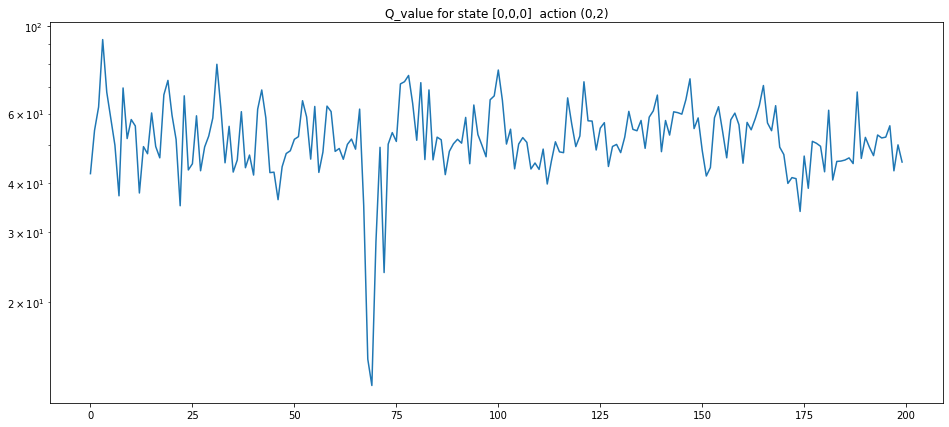

In [13]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [14]:
score_tracked_sample = [score_tracked[i] for i in range(len(score_tracked)) if (i % 4 == 0)]

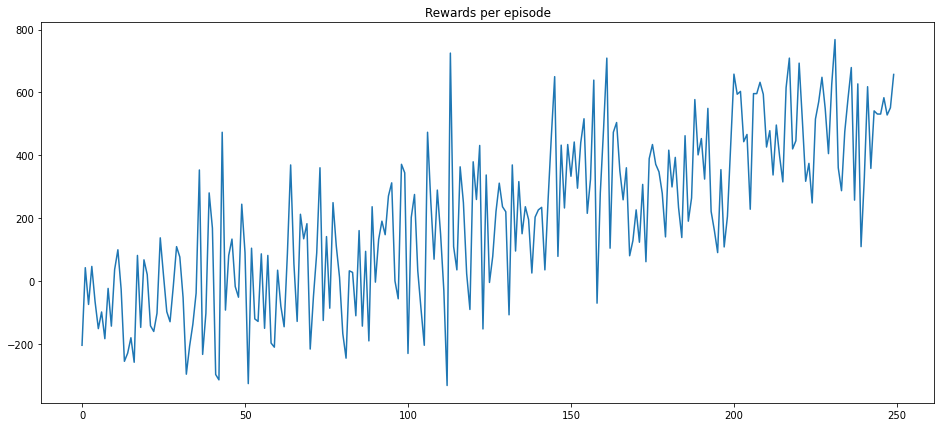

In [15]:
plt.figure(0, figsize=(16,7))
plt.title('Rewards per episode')
xaxis = np.asarray(range(0, len(score_tracked_sample)))
plt.plot(xaxis,np.asarray(score_tracked_sample))
plt.show()

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [16]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

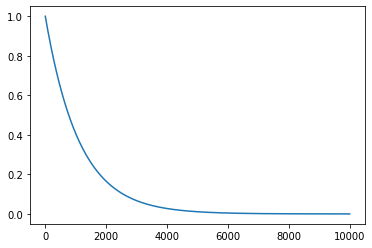

In [17]:
plt.plot(time, epsilon)
plt.show()